# SoundCloud: Data Analysis of Likes & Import to Spotify Functionality

## Introduction

This project is a bit more of a personal project than the others posted thus far. I've been meaning to transfer my SoundCloud library of likes to a Spotify playlist for quite some time now, but have always dreaded the task of manually doing so. While coming up with project ideas I figured now would be a great time to finally transfer my playlist, but in a more automatic fashion.

The goal of this project is to collect all of the liked tracks from a SoundCloud user, perform some analysis on their liked tracks similar to that of Spotify's "Wrapped" or "Year in Review" summaries, and import all tracks to a SoundCloud playlist.

To accomplish this task, the user's liked tracks will be scraped directly from SoundCloud, as allowed by their robots.txt file. Web scraping was chosen over the use of an API since SoundCloud has closed their API registrations for the time being. The data will be cleaned, analyzed, visualized, and then imported into a Spotify playlist using Spotipy, a Python library for the Spotify Web API.

## Importing Libraries and Setting Up

The `selenium`, `time`, `bs4`,`re`, and `pandas` libraries are used to scrape and clean liked tracks from a SoundCloud user's profile into a DataFrame. The `matplotlib` and `seaborn` libraries are used for data visualization, while `spotipy` is used to access Spotify features such as playlist creation and adding tracks to a playlist. I have also hidden away some variables containing information regarding the application's credentials in another file named `app_credentials`, which is imported for use here as well.

In [1]:
from selenium import webdriver
import time
from bs4 import BeautifulSoup
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import spotipy
import spotipy.util as util
# App credentials
from app_credentials import client_id, client_secret, redirect_uri

Next we will input the user's SoundCloud profile URL and Spotify user ID.

In [2]:
soundcloud_profile_url = 'https://soundcloud.com/kai-chang-4/'
spotify_user_id = '128095480'

## Gathering the Data

We can now begin to scrape data from the user's SoundCloud profile. The HTML will be stored within a `BeautifulSoup` object called `soup` for parsing.

In [3]:
driver = webdriver.Chrome('C:\Chromedriver\chromedriver.exe')
driver.get('{0}likes'.format(soundcloud_profile_url))
time.sleep(1)

# Manage infinite scrolling page
last_height = driver.execute_script('return document.body.scrollHeight')
while True:
    driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')
    time.sleep(2)
    new_height = driver.execute_script('return document.body.scrollHeight')
    if new_height == last_height:
        break
    else:
        last_height = new_height

soup = BeautifulSoup(driver.page_source, 'html.parser')
driver.quit()

## Overview of the Data

A DataFrame with the columns `track_title`, `uploader`, `genre`, and `plays` can then be created by parsing relevant data from the `soup` object.

In [4]:
table = []
columns = ['track_title', 'uploader', 'genre', 'plays']

songs = soup.find_all('li', attrs={'class': 'soundList__item'})

for song in songs:
    track_title = song.find('div', attrs={'class': 'soundTitle__usernameTitleContainer'}).find_all('a')[1].text.strip()
    uploader = song.find('div', attrs={'class': 'soundTitle__usernameTitleContainer'}).find_all('a')[0].text.strip()
    try:
        genre = song.find('a', attrs={'class': 'soundTitle__tag sc-tag sc-tag-small'}).text.strip()
    except AttributeError:
        genre = None
    try:
        plays = int(song.find('span', attrs={'class': 'sc-ministats sc-ministats-small sc-ministats-plays'})\
                        .get_text('|').split('|')[1].split()[0].replace(',', ''))
    except AttributeError:
        plays = None
        
    row = [track_title, uploader, genre, plays]
    table.append(row)
    
df = pd.DataFrame(table, columns=columns)
    
df

,track_title,uploader,genre,plays
0,Natural (feat Tima Dee),JAMEO,Future Bass,6910.0
1,Taska Black - In Your Eyes (ft. Ayelle),TASKA BLACK,Electronic,655371.0
2,Better Not (with Wafia),Louis The Child,Electronic,3819688.0
3,DROELOE x San Holo - Lines of the Broken (ft. ...,bitbird,Electronic,3063553.0
4,DROELOE - BACKBONE ft. Nevve,bitbird,Electronic,1339065.0
...,...,...,...,...
529,Wasted Penguinz - Melancholia,Wasted Penguinz,Hardstyle,448517.0
530,Love This Life (ft Murda),Psyko Punkz,hardstyle,168608.0
531,Waverider - The Way (#SCAN154 Preview),Scantraxx,Scantraxx,21864.0
532,Frontliner & Synthsoldier - The New Age,Synthsoldier,Collab,38128.0


## Modifying the Data

Since SoundCloud tracks can be uploaded by any user and lack a rigid syntax method for naming, there is significant variety in the different syntax methods used to name tracks or genres. For example, the listed genre may not be accurate, or may have different capitalization than others. The uploader of a track also may or may not be the artist, as music labels or regular users may be uploaders as well. We will have to attempt to manage these inconsistencies in order to parse the information we want into a clean DataFrame.

To start, all string columns will be converted to lowercase.

In [5]:
df['track_title'] = df['track_title'].str.lower()
df['uploader'] = df['uploader'].str.lower()
df['genre'] = df['genre'].str.lower()

The most difficult part of this project will be properly parsing the artist and track title from each track. No additional attempt will be made to correct genres, as many of the tagged genres are not in fact genres but the artists themselves, their music label, or other miscellaneous items.

In order to parse the artist and track title from each track, we will make three main assumptions.

* If "- " is in the raw track title, then the artist precedes the dash while the track title follows the dash
    * ***artist*** - ***track title*** | *uploader*
* The above is true unless syntax similar to (*artist* remix) is present within the raw track title. If that is the case, then both the artist and the track title lie on the same side of the dash
    * *original artist* - ***track title*** (***artist*** remix) | *uploader*
    * This is only true if syntax similar to (original remix) or (original mix) is not present. Otherwise, the artist will precede the dash and the track title will follow the dash
        * ***artist*** - ***track title*** (original mix) | *uploader*
* If "- " is not present within the raw track title, then the uploader will be the assumed artist and the track title will equal the raw track title
    * ***track title*** | *uploader* = ***artist***
    
With some minor tweaks the above assumptions cover the majority of tracks, however some tracks are labeled in such a way that makes automatic data parsing highly difficult. For example, some tracks may have the track title preceding a dash and the artist following the dash, or they may be missing parenthesis or other delimiters and be titled similar to "*track title* *artist* remix." No additional attempt will be made to better clean and parse information from data formatted in such a way as doing so is beyond the scope of this project.

In [6]:
pd.options.mode.chained_assignment = None
def cleaner(df):
    artist_indicators = ' (remix|rmx|mix|flip|remake|edit|cover)\s*[\)\]]'
    not_artist_indicators = '(orig(\.)?(inal)?|radio|club) (remix|rmx|mix|flip|remake|edit|cover|mashup)\s*[\)\]]'
    multiple_artists_indicators = ' & | x |,| and '
    feature_indicators_a = '[ \(]f(ea)?t(uring)?[ \.]'
    feature_indicators_b = '[ \(]f(ea)?t(uring)?[ \.]| with '

    df['artist'] = None
    df['adjusted_track_title'] = None

    def clean_artist_string(x):
        return re.sub('.*[\)\(\[]', '', re.split(artist_indicators, x)[0])
    
    def clean_title_string(x):
        if '\"' in x:
            return re.split('\"', re.sub('\*[^\*]*\*', '', re.sub('[\[\(].*[\)\]]', '', x)))[1].replace('\'', '')
        else:
            return re.split('\"', re.sub('\*[^\*]*\*', '', re.sub('[\[\(].*[\)\]]', '', x)))[0].replace('\'', '')

    def drop_features(x, feature_indicators):
        if re.search(feature_indicators, x):
            return re.split(feature_indicators, x)[0]
        else:
            return x
        
    def split_multiple_artists(x):
        if re.search(multiple_artists_indicators, x):
            result = re.split(multiple_artists_indicators, x)
            return [string.strip() for string in result if string]
        else:
            return re.split(multiple_artists_indicators, x.strip())
    
    # Split track_title string into title and artist strings, features may be in either string and will be dropped later
    for row in df.itertuples():
        # If '- ' is present, then artist and title are in track title, which will be split with '- '
        if '- ' in row.track_title:
            split = row.track_title.split('- ')
            for string in split:
                # If artist_indicators such as 'remix' are present and not_artist_indicators such as 'original mix'
                # are not present, then substring contains both artist and title
                # E.g. original_artist - song_title (artist remix)
                if re.search(artist_indicators, string) and not re.search(not_artist_indicators, string):
                    df['artist'].iloc[row.Index] = string
                    df['adjusted_track_title'].iloc[row.Index] = string
            # If above indicators are not present, then artist string precedes title string
            # E.g. artist - song_title
            if not df['artist'].iloc[row.Index]:
                df['artist'].iloc[row.Index] = split[0]
                df['adjusted_track_title'].iloc[row.Index] = split[1]
        # If '- ' is not present, then artist = uploader and song = title
        else:
            df['artist'].iloc[row.Index] = row.uploader
            df['adjusted_track_title'].iloc[row.Index] = row.track_title
            
    # Clean results
    df['artist'] = df['artist'].apply(clean_artist_string)\
                               .apply(drop_features, feature_indicators = feature_indicators_b)\
                               .apply(split_multiple_artists)
    df['adjusted_track_title'] = df['adjusted_track_title'].apply(clean_title_string)\
                                                           .apply(drop_features, feature_indicators = feature_indicators_a)
    df['track_title'] = df['adjusted_track_title'].str.strip()
    
    return df[['track_title', 'artist', 'genre', 'plays']]
    
df = cleaner(df)

df

,track_title,artist,genre,plays
0,natural,[jameo],future bass,6910.0
1,in your eyes,[taska black],electronic,655371.0
2,better not,[louis the child],electronic,3819688.0
3,lines of the broken,"[droeloe, san holo]",electronic,3063553.0
4,backbone,[droeloe],electronic,1339065.0
...,...,...,...,...
529,melancholia,[wasted penguinz],hardstyle,448517.0
530,love this life,[psyko punkz],hardstyle,168608.0
531,the way,[waverider],scantraxx,21864.0
532,the new age,"[frontliner, synthsoldier]",collab,38128.0


## Analysis of Liked Tracks

Now that our DataFrame is relatively clean, we can begin analyzing our liked tracks and displaying visualizations for the user.

We will begin by visualizing the user's favorite genres. Genre counts of eight and higher are chosen for visualization for this particular user.

In [7]:
genre_counts = df.genre.value_counts().reset_index().rename(columns={'index': 'genre', 'genre': 'counts'})
genre_counts

,genre,counts
0,dance,50
1,progressive house,46
2,electronic,40
3,hardstyle,35
4,dance & edm,26
...,...,...
182,electronic house,1
183,revolution,1
184,lean on,1
185,gunz for hire,1


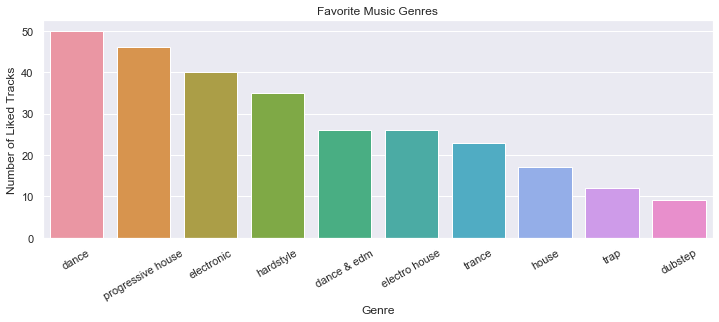

In [8]:
bar_data = genre_counts[genre_counts.counts >= 8]

sns.set(style='darkgrid', palette='husl')
fig, ax = plt.subplots(figsize=(12, 4))
sns.barplot(data=bar_data, x='genre', y='counts')
plt.xticks(rotation=30)
ax.set_title("Favorite Music Genres")
ax.set_xlabel('Genre')
ax.set_ylabel('Number of Liked Tracks')
plt.show()

Next we will determine favorite artists for the user. Only artists where the user has liked at least five of their tracks are shown.

In [9]:
artist_counts = df.artist.explode().value_counts().reset_index().rename(columns={'index': 'artist', 'artist': 'counts'})
artist_counts

,artist,counts
0,vicetone,11
1,tritonal,10
2,dj snake,10
3,martin garrix,9
4,borgore,8
...,...,...
392,awakend,1
393,eximinds,1
394,swedish.house.mafia,1
395,nÿls,1


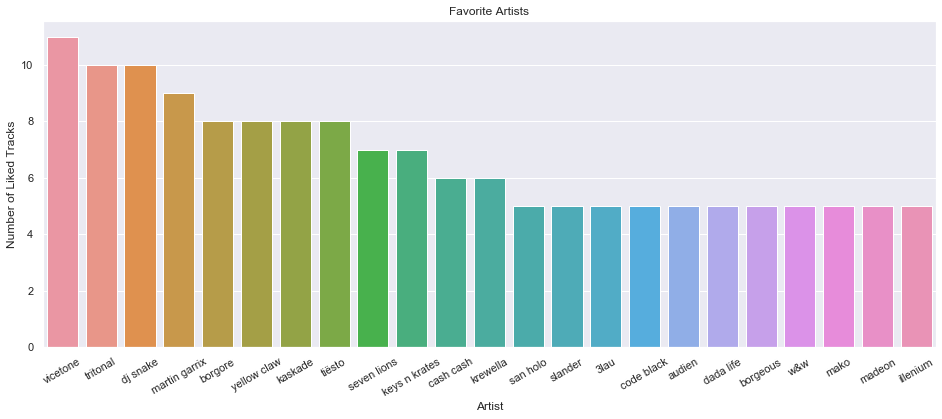

In [10]:
bar_data = artist_counts[artist_counts.counts >= 5]

fig, ax = plt.subplots(figsize=(16, 6))
sns.barplot(data=bar_data, x='artist', y='counts')
plt.xticks(rotation=30)
ax.set_title("Favorite Artists")
ax.set_xlabel('Artist')
ax.set_ylabel('Number of Liked Tracks')
plt.show()

We will also create histograms of play counts for liked tracks to determine how popular the user's music is. The first histogram will account for all liked tracks, while the second histogram will zoom in slightly to focus on the majority of the data.

In [11]:
df.plays.isnull().value_counts()

False    530
True       4
Name: plays, dtype: int64

In [12]:
df[df.plays.notnull()].plays.sort_values()

141          958.0
284         1543.0
478         1694.0
93          2666.0
399         3030.0
          ...     
324     70329370.0
331     72473063.0
256     73609437.0
81      74304123.0
194    172763171.0
Name: plays, Length: 530, dtype: float64

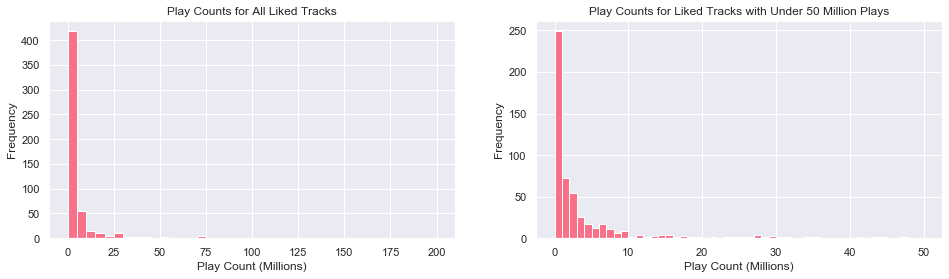

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.hist(df[df.plays.notnull()].plays, range=(0, 200000000), bins=40)
ax1.set_title("Play Counts for All Liked Tracks")
ax1.set_xlabel('Play Count (Millions)')
ax1.set_xticks(range(0, 225000000, 25000000))
ax1.set_xticklabels(['0', '25', '50', '75', '100', '125', '150', '175', '200'])
ax1.set_ylabel('Frequency')

ax2.hist(df[df.plays.notnull()].plays, range=(0, 50000000), bins=50)
ax2.set_title("Play Counts for Liked Tracks with Under 50 Million Plays")
ax2.set_xlabel('Play Count (Millions)')
ax2.set_xticks(range(0, 60000000, 10000000))
ax2.set_xticklabels(['0', '10', '20', '30', '40', '50'])
ax2.set_ylabel('Frequency')

plt.show()

In [14]:
print("The mean play count for your liked tracks is: {0}".format(df[df.plays.notnull()].plays.mean()))
print("The median play count for your liked tracks is: {0}".format(df[df.plays.notnull()].plays.median()))
print("The standard deviation for play counts for your liked tracks is: {0}".format(df[df.plays.notnull()].plays.std()))
print("The minimum value for play counts for your liked tracks is: {0}".format(df[df.plays.notnull()].plays.min()))
print("The maximum value for play counts for your liked tracks is: {0}".format(df[df.plays.notnull()].plays.max()))

The mean play count for your liked tracks is: 4993711.156603773
The median play count for your liked tracks is: 1180641.0
The standard deviation for play counts for your liked tracks is: 12556629.879246298
The minimum value for play counts for your liked tracks is: 958.0
The maximum value for play counts for your liked tracks is: 172763171.0


This particular distribution is extremely skewed right. Nine data points, out of a total of 530, lie beyond the 50 million play count cut-off point for the second histogram. Some basic statistics are printed above.

## Importing to Spotify Playlist

The final portion of this project will handle automatically importing the user's SoundCloud likes to a Spotify playlist. We will start by creating a dictionary containing track information from our DataFrame.

In [15]:
track_dict = {}
for idx, row in enumerate(df.itertuples()):
    track_dict[idx] = row

The following cell is used to make our application's print output scrollable in nbviewer.

In [16]:
%%html
<style>
.nbviewer div.output_area {
  overflow-y: auto;
  max-height: 500px; /* or value of your choosing */
}
</style>

We will then use Spotify's Spotipy library to create a playlist for the user, find track IDs that match tracks in the above dictionary, and add those tracks to our playlist. Tracks will first be searched for using the specific track title and artist(s) in the query. If no match is found, then tracks will be searched for using track title alone. A final print-out will tell the user which tracks were found with the specific artist and track title, which tracks were found with track title alone, and which tracks could not be found at all.

In [17]:
class SoundCloudToSpotify:
    scope = "playlist-modify-public"
    
    def __init__(self, username):
        self.username = username
        self.token = util.prompt_for_user_token(self.username, self.scope, client_id=client_id,
                                                client_secret=client_secret, redirect_uri=redirect_uri)
        self.sp = spotipy.Spotify(auth=self.token)
        self.sp.trace = False
        
    def create_playlist(self, playlist_name, playlist_description):
        playlist = self.sp.user_playlist_create(self.username, playlist_name, description=playlist_description)
        self.playlist_id = playlist['id']
    
    def get_spotify_track_ids(self, track_dict):
        self.track_ids = []
        specific_tracks = []
        nonspecific_tracks = []
        unable_to_find_tracks = []
                    
        for row in track_dict.values():
            artist_list = row.artist
            track = row.track_title
            idx = 0
            artist = artist_list[idx]
            result = self.sp.search(q='artist:{0} track:{1}'.format(artist, track), limit=1, type='track', market='US')
            while not result['tracks']['items'] and idx < (len(artist_list) - 1):
                idx += 1
                artist = artist_list[idx]
                result = self.sp.search(q='artist:{0} track:{1}'.format(artist, track), limit=1, type='track', market='US')
            if result['tracks']['items']:
                self.track_ids.append(result['tracks']['items'][0]['id'])
                specific_tracks.append((artist, track))
            else:
                result = self.sp.search(q='{0}'.format(track), limit=1, type='track', market='US')
                if result['tracks']['items']:
                    self.track_ids.append(result['tracks']['items'][0]['id'])
                    nonspecific_tracks.append((artist, track))
                else:
                    unable_to_find_tracks.append((artist, track))
             
        print("The following tracks were added with the specified artist and track title:")
        for (artist, track) in specific_tracks:
            print("{0}: {1}".format(artist, track))
        print()
        print("The following tracks could only be found by not specifying track information",
              "and may not have matched as intended:")
        for (artist, track) in nonspecific_tracks:
            print("{0}: {1}".format(artist, track))
        print()
        print("The following tracks could not be found:")
        for (artist, track) in unable_to_find_tracks:
            print("{0}: {1}".format(artist, track))
            
    def import_tracks_to_playlist(self, playlist_name, playlist_description, track_dict):
        self.create_playlist(playlist_name, playlist_description)
        self.get_spotify_track_ids(track_dict)
        # Spotipy allows us to add a maximum of 100 tracks at a time
        while self.track_ids:
            self.sp.user_playlist_add_tracks(self.username, self.playlist_id, self.track_ids[:100])
            self.track_ids = self.track_ids[100:]
        
user = SoundCloudToSpotify(spotify_user_id)
user.import_tracks_to_playlist("SoundCloud Tracks", "Tracks from SoundCloud Likes", track_dict)

The following tracks were added with the specified artist and track title:
jameo: natural
taska black: in your eyes
louis the child: better not
droeloe: lines of the broken
droeloe: backbone
david guetta: just one last time
hardwell: can hold us down
dj snake: loco contigo
blu j: golden dreams
san holo: i still see your face
phuture noize: circles and squares
eric prydz: opus
gryffin: all you need to know
cole plante: if i fall
nick gunner: lucid dreaming
lejend: rise above
ghastly: we might fall
said the sky: pray for me
sweater beats: symphony
droeloe: sunburn
boombox cartel: whisper
illenium: god damnit
ekali: forever
ekali: helios
adventure club: crash 2.0
don diablo: on my mind
breathe carolina: stars & moon
elephante: the in between
prxzm: silence
darren styles: us against the world
seven lions: calling you home
seven lions: horizon
seven lions: freesol
dabin: hold
ran-d: zombie
vavo: sleeping alone
avicii: the nights
super8: seconds away
darude: surrender
noah neiman: push
w&w: 

## Summary and Closing Thoughts

The goal of this project was to take a user's SoundCloud likes, perform some analysis on those liked tracks similar to that of Spotify's "Wrapped" or "Year in Review" summaries, and automatically import those liked tracks into a Spotify playlist. Unfortunately, we do not have access to the full listening history for users, and thus are unable to show metrics such as how many minutes they spent listening to certain artists or genres, or how many hours they typically spent listening to music per week. However, we were able to show the user's favorite artists and genres, as well as display a histogram of play counts for liked tracks from the data that we had available. There was also difficulty in properly cleaning and parsing information such as artist name or track title from the raw data due to the large amount of variation present within the naming syntax. Despite this, we were able to parse the correct information for the majority of tracks. Ultimately, our project accomplishes what it was designed for with good accuracy and results, however does leave room for future improvement.